In [1]:
# Import dependencies
import torch
from PIL import Image

from torch import nn, save, load
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

import matplotlib.pyplot as plt

In [ ]:
# Check device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
train = datasets.MNIST(root="data", download=True, train=True, transform=ToTensor())
dataset = DataLoader(train, 32)

In [3]:
# Build configuration
CONFIG = {
    'IM_SIZE' : 28,
}

In [4]:
# Build model
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (3, 3)),
            nn.ReLU(),
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*(CONFIG['IM_SIZE']-6)*(CONFIG['IM_SIZE']-6), 10)
        )
    
    def forward(self, x):
        return self.model(x)

# Instance of the NN, loss, optimizer
clf = ImageClassifier().to(device)
opt_clf = Adam(clf.parameters(), lr=1e-3)
loss_fn_clf = nn.CrossEntropyLoss()
summary(clf, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          36,928
              ReLU-6           [-1, 64, 22, 22]               0
           Flatten-7                [-1, 30976]               0
            Linear-8                   [-1, 10]         309,770
Total params: 365,514
Trainable params: 365,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.60
Params size (MB): 1.39
Estimated Total Size (MB): 3.00
----------------------------------------------------------------


In [ ]:
# Build model
class ImageClassifier(nn.Module):
    def __init__(self):
        super(ImageClassifier, self).__init__()
        self.c1 = nn.Conv2d(1, 32, (3, 3))
        self.c2 = nn.Conv2d(32, 64, (3, 3))
        self.c3 = nn.Conv2d(64, 64, (3, 3))
        self.fc =nn.Linear(64*(CONFIG['IM_SIZE']-6)*(CONFIG['IM_SIZE']-6), 10)
    
    def forward(self, x):
        x = self.c1(x)
        x = F.relu(x)
        x = self.c2(x)
        x = F.relu(x)
        x = self.c3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instance of the NN, loss, optimizer
subc = ImageClassifier().to(device)
opt_subc = Adam(subc.parameters(), lr=1e-3)
loss_fn_subc = nn.CrossEntropyLoss()
summary(subc, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3           [-1, 64, 22, 22]          36,928
            Linear-4                   [-1, 10]         309,770
Total params: 365,514
Trainable params: 365,514
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.68
Params size (MB): 1.39
Estimated Total Size (MB): 2.08
----------------------------------------------------------------


In [7]:
# Training flow
def train_model(mode_train=True, model=clf, m_loss=loss_fn_clf, m_opt=opt_clf, epochs=10):
    if mode_train:
        if __name__ == "__main__":
            for epoch in range(epochs):
                for batch in dataset:
                    X, y = batch
                    X, y = X.to(device), y.to(device)
                    yhat = model(X)
                    loss = m_loss(yhat, y)

                    # Apply backprop
                    m_opt.zero_grad()
                    loss.backward()
                    m_opt.step()

                print(f"Epoch: {epoch+1} have loss is {loss.item()}")

            with open('../model_checkpoint/model_state.pt', 'wb') as f:
                save(model.state_dict(), f)
    else:
        with open('../model_checkpoint/model_state.pt', 'rb') as f:
            model.load_state_dict(load(f, weights_only=True))

# Use define
# train_model(mode_train=True, model=clf, m_loss=loss_fn_clf, m_opt=opt_clf, epochs=10)
train_model(mode_train=False)

In [ ]:
# Use model 
def pred(src, model):
    img = Image.open(src)
    img_tensor = ToTensor()(img).unsqueeze(0).to(device)
    pred = torch.argmax(model(img_tensor))
    print(pred)
    print("Predicted labels:", pred.cpu().numpy())

# Use define
pred(src="../image/img_2.jpg", model=clf)

tensor(0, device='cuda:0')
Predicted labels: 0


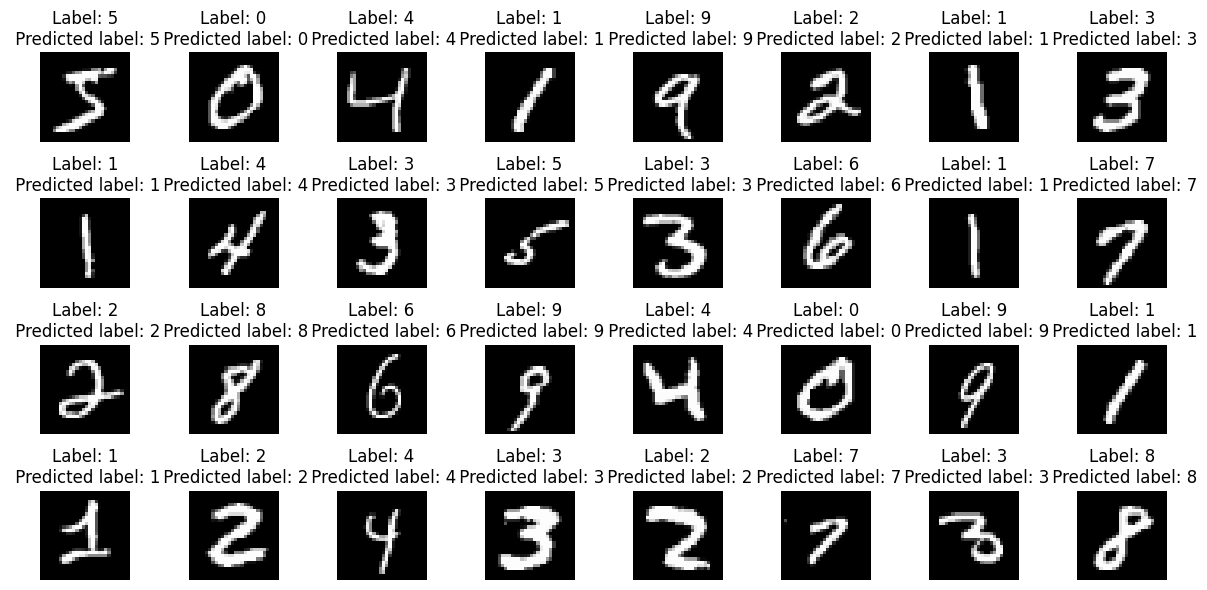

In [38]:
images, labels = next(iter(dataset))

# Create a grid of images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()

for img, label, ax in zip(images, labels, axes):
    img_tensor = ToTensor()(img.squeeze().numpy()).unsqueeze(0).to(device)
    pred = torch.argmax(clf(img_tensor))
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {label.item()}" + 
                 f"\n Predicted label: {pred.cpu().numpy()}")
    ax.axis("off")

plt.tight_layout()
plt.show()